In [335]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RegNet(nn.Module):
    def __init__(self):
        super(RegNet, self).__init__()
        self.fc1 = nn.Linear(500,500)
        self.fc2 = nn.Linear(500,500)
        self.fc3 = nn.Linear(500,1,bias=False)
        self.dropout = nn.Dropout(0.25)
        self.thr = nn.Sigmoid()
        self.thr1 = nn.ReLU()
        self.thr2 = nn.LeakyReLU(0.1)

    def forward(self,x):
        #x=self.thr2(self.fc1(x))
        x=self.thr2(self.fc2(x))
        x=self.thr(self.fc3(x))
        return x 

#import hdf5storage
#mat = hdf5storage.loadmat('wrongsource.mat') 
import scipy.io
mat = scipy.io.loadmat('wrongsource.mat')

import torch
#import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pylab as plt
import pickle
import scipy.io as sio
dtype = torch.float32
device = torch.device("cpu")

torch.set_default_dtype(torch.float32)
H_right=mat['source']
H_wrong=mat['wsource']

#Convert into torch arrays
Hr=torch.from_numpy(H_right)
Hw=torch.from_numpy(H_wrong)

nValidation=100
nTrain=Hr.shape[1]-nValidation

print(nTrain)
#Hr=Hr[:,0:500]
#Hw=Hw[:,0:500]
# initial scrambling 
perm = torch.randperm(nTrain+nValidation)
Hr = Hr[:,perm]
Hw = Hw[:,perm]

# validation dataset
val_r = Hr[:,-nValidation:]
val_w = Hw[:,-nValidation:]


N=50
nEpochs=1000

net1 = RegNet()
net1 = net1.float()

# Loss and optimizer
learning_rate = 1e-3
optimizer = torch.optim.SGD(net1.parameters(), lr=learning_rate)


#with torch.no_grad():
#    net1.fc2.weight.data = torch.abs(net1.fc2.weight.data)/torch.norm(net1.fc2.weight.data,2)


beta=0.0007
beta1=0.0007
beta5 = 0.0002
for t in range(nEpochs):
    tloss=0
    ndloss=0
    sploss = 0
    perm = torch.randperm(nTrain)
    for b_ix in np.arange(0,nTrain,N):
        
        
        ##Pre-processing sparse codes for input 
        #xr=Hr[:,perm[b_ix:b_ix+N]].reshape(N,Hr.shape[0])
        #xw=Hw[:,perm[b_ix:b_ix+N]].reshape(N,Hw.shape[0])
        xr=Hr[:,perm[b_ix:b_ix+N]].transpose(0,1) #+ torch.rand(N,500).type(dtype=torch.float64)*0.1
        xw=Hw[:,perm[b_ix:b_ix+N]].transpose(0,1) #+ torch.rand(N,500).type(dtype=torch.float64)*0.1
        optimizer.zero_grad()
    
        normr = net1(xr.float()).type(dtype=torch.float64)
        normw = net1(xw.float()).type(dtype=torch.float64)
        spp = beta5 *torch.abs((normr - torch.abs(torch.sum(xr,1)))).sum()
        ndiff = (normr-normw).sum() 
        
        
        #loss1 = (normr-normw).sum() + beta5*torch.abs((normr.sum()-torch.sum(torch.abs(xr))))#/(N*(torch.max(torch.abs(normw-normr)))) # + beta*torch.norm(net1.fc2.weight.data,2) + beta1*torch.norm(net1.fc1.weight.data,2)
        loss1 =  ndiff + spp
        
        
       
        # Backward and optimize
        
        loss1.backward()
        optimizer.step()
        
        #for p in net1.parameters():
        #    p.data.clamp_(0)
        #with torch.no_grad():
        #    net1.fc1.weight.data = self.thr(net1.fc1.weight.data)  ##Projecting the weights to positive
        #    net1.fc2.weight.data = self.thr(net1.fc2.weight.data)
        tloss=tloss+loss1
        ndloss = ndloss + ndiff
        sploss = sploss + spp
        
        
        with torch.no_grad():
            #loss = (normw-normr).sum()/(N*(torch.max(torch.abs(normw-normr))))
            #tl=tl+loss

                
            if b_ix / N == (nTrain/N)-1:
                print('Epoch:{:d}| Average Epoch loss:{:.20f}| Ndiff loss:{:.10f}|Sparsity loss:{:.10f} '.format(t+1, tloss/(nTrain/N),ndloss/(nTrain/N),sploss/(nTrain/N)))
                print(net1.fc1.weight.sum())
                print(net1.fc2.weight.sum())
                

900
Epoch:1| Average Epoch loss:35.84172582048043409486| Ndiff loss:-13.9173364951|Sparsity loss:49.7590623156 
tensor(-5.0163)
tensor(-33.7797)
Epoch:2| Average Epoch loss:26.70470602267111104311| Ndiff loss:-23.0844653505|Sparsity loss:49.7891713732 
tensor(-5.0163)
tensor(-64.2286)
Epoch:3| Average Epoch loss:16.75217387267905877479| Ndiff loss:-33.0386043640|Sparsity loss:49.7907782366 
tensor(-5.0163)
tensor(-63.8692)
Epoch:4| Average Epoch loss:9.45565267704918355207| Ndiff loss:-40.3433353892|Sparsity loss:49.7989880662 
tensor(-5.0163)
tensor(-52.6555)
Epoch:5| Average Epoch loss:5.94835939578368932956| Ndiff loss:-43.8601927727|Sparsity loss:49.8085521685 
tensor(-5.0163)
tensor(-43.9161)
Epoch:6| Average Epoch loss:4.18540060940408764623| Ndiff loss:-45.6285141320|Sparsity loss:49.8139147414 
tensor(-5.0163)
tensor(-36.9281)
Epoch:7| Average Epoch loss:3.16913571589855891375| Ndiff loss:-46.6481935817|Sparsity loss:49.8173292976 
tensor(-5.0163)
tensor(-31.4324)
Epoch:8| Aver

Epoch:60| Average Epoch loss:0.07098213924523871787| Ndiff loss:-49.7570460299|Sparsity loss:49.8280281691 
tensor(-5.0163)
tensor(30.4805)
Epoch:61| Average Epoch loss:0.06690304692519274954| Ndiff loss:-49.7611465248|Sparsity loss:49.8280495717 
tensor(-5.0163)
tensor(30.8671)
Epoch:62| Average Epoch loss:0.06300283539967803381| Ndiff loss:-49.7650665592|Sparsity loss:49.8280693946 
tensor(-5.0163)
tensor(31.2090)
Epoch:63| Average Epoch loss:0.05923912387184810530| Ndiff loss:-49.7688480185|Sparsity loss:49.8280871424 
tensor(-5.0163)
tensor(31.5493)
Epoch:64| Average Epoch loss:0.05559732614133178902| Ndiff loss:-49.7724951262|Sparsity loss:49.8280924523 
tensor(-5.0163)
tensor(31.9148)
Epoch:65| Average Epoch loss:0.05206985673510584195| Ndiff loss:-49.7760421952|Sparsity loss:49.8281120520 
tensor(-5.0163)
tensor(32.2557)
Epoch:66| Average Epoch loss:0.04865837900958069895| Ndiff loss:-49.7794734385|Sparsity loss:49.8281318175 
tensor(-5.0163)
tensor(32.5406)
Epoch:67| Average Ep

tensor(-5.0163)
tensor(44.8659)
Epoch:119| Average Epoch loss:-0.04828026172125356175| Ndiff loss:-49.8767938429|Sparsity loss:49.8285135811 
tensor(-5.0163)
tensor(45.0420)
Epoch:120| Average Epoch loss:-0.04927987376043792972| Ndiff loss:-49.8777963751|Sparsity loss:49.8285165014 
tensor(-5.0163)
tensor(45.2331)
Epoch:121| Average Epoch loss:-0.05028279628928760542| Ndiff loss:-49.8788071015|Sparsity loss:49.8285243053 
tensor(-5.0163)
tensor(45.3838)
Epoch:122| Average Epoch loss:-0.05124729517602114731| Ndiff loss:-49.8797721124|Sparsity loss:49.8285248172 
tensor(-5.0163)
tensor(45.5491)
Epoch:123| Average Epoch loss:-0.05221229802392891861| Ndiff loss:-49.8807452592|Sparsity loss:49.8285329611 
tensor(-5.0163)
tensor(45.7010)
Epoch:124| Average Epoch loss:-0.05317126251838880796| Ndiff loss:-49.8817012250|Sparsity loss:49.8285299625 
tensor(-5.0163)
tensor(45.8953)
Epoch:125| Average Epoch loss:-0.05409153034412818306| Ndiff loss:-49.8826325148|Sparsity loss:49.8285409844 
tensor

tensor(-5.0163)
tensor(52.8183)
Epoch:178| Average Epoch loss:-0.08850348303238123049| Ndiff loss:-49.9171841590|Sparsity loss:49.8286806759 
tensor(-5.0163)
tensor(52.9281)
Epoch:179| Average Epoch loss:-0.08896508502338523749| Ndiff loss:-49.9176474337|Sparsity loss:49.8286823487 
tensor(-5.0163)
tensor(53.0365)
Epoch:180| Average Epoch loss:-0.08941801345256233935| Ndiff loss:-49.9181034982|Sparsity loss:49.8286854847 
tensor(-5.0163)
tensor(53.1318)
Epoch:181| Average Epoch loss:-0.08987817318414631496| Ndiff loss:-49.9185628526|Sparsity loss:49.8286846794 
tensor(-5.0163)
tensor(53.2584)
Epoch:182| Average Epoch loss:-0.09032747041682674671| Ndiff loss:-49.9190179662|Sparsity loss:49.8286904958 
tensor(-5.0163)
tensor(53.3468)
Epoch:183| Average Epoch loss:-0.09077222932001068056| Ndiff loss:-49.9194597631|Sparsity loss:49.8286875338 
tensor(-5.0163)
tensor(53.4763)
Epoch:184| Average Epoch loss:-0.09120900052824509885| Ndiff loss:-49.9199031762|Sparsity loss:49.8286941757 
tensor

tensor(-5.0163)
tensor(58.1084)
Epoch:236| Average Epoch loss:-0.10926058230953354655| Ndiff loss:-49.9380223740|Sparsity loss:49.8287617917 
tensor(-5.0163)
tensor(58.2461)
Epoch:237| Average Epoch loss:-0.10951404824561371265| Ndiff loss:-49.9382891798|Sparsity loss:49.8287751316 
tensor(-5.0163)
tensor(58.2833)
Epoch:238| Average Epoch loss:-0.10979871952180768335| Ndiff loss:-49.9385638814|Sparsity loss:49.8287651618 
tensor(-5.0163)
tensor(58.4003)
Epoch:239| Average Epoch loss:-0.11005131346714788765| Ndiff loss:-49.9388282702|Sparsity loss:49.8287769567 
tensor(-5.0163)
tensor(58.4419)
Epoch:240| Average Epoch loss:-0.11032816664044393928| Ndiff loss:-49.9390948961|Sparsity loss:49.8287667294 
tensor(-5.0163)
tensor(58.5687)
Epoch:241| Average Epoch loss:-0.11057849010703711679| Ndiff loss:-49.9393581700|Sparsity loss:49.8287796799 
tensor(-5.0163)
tensor(58.5968)
Epoch:242| Average Epoch loss:-0.11084445250481028689| Ndiff loss:-49.9396140812|Sparsity loss:49.8287696287 
tensor

Epoch:295| Average Epoch loss:-0.12198584628627766324| Ndiff loss:-49.9508115002|Sparsity loss:49.8288256539 
tensor(-5.0163)
tensor(62.2644)
Epoch:296| Average Epoch loss:-0.12216528832128561999| Ndiff loss:-49.9509862683|Sparsity loss:49.8288209800 
tensor(-5.0163)
tensor(62.3484)
Epoch:297| Average Epoch loss:-0.12233073805522604038| Ndiff loss:-49.9511582595|Sparsity loss:49.8288275214 
tensor(-5.0163)
tensor(62.3767)
Epoch:298| Average Epoch loss:-0.12250279287364228276| Ndiff loss:-49.9513244059|Sparsity loss:49.8288216130 
tensor(-5.0163)
tensor(62.4690)
Epoch:299| Average Epoch loss:-0.12266468925382728594| Ndiff loss:-49.9514944191|Sparsity loss:49.8288297298 
tensor(-5.0163)
tensor(62.4916)
Epoch:300| Average Epoch loss:-0.12283582674660564749| Ndiff loss:-49.9516583325|Sparsity loss:49.8288225058 
tensor(-5.0163)
tensor(62.5857)
Epoch:301| Average Epoch loss:-0.12299275512196355953| Ndiff loss:-49.9518239558|Sparsity loss:49.8288312007 
tensor(-5.0163)
tensor(62.6065)
Epoch:

tensor(-5.0163)
tensor(65.4242)
Epoch:354| Average Epoch loss:-0.13058516041171033817| Ndiff loss:-49.9594452084|Sparsity loss:49.8288600480 
tensor(-5.0163)
tensor(65.4712)
Epoch:355| Average Epoch loss:-0.13070789855483708197| Ndiff loss:-49.9595680741|Sparsity loss:49.8288601756 
tensor(-5.0163)
tensor(65.5244)
Epoch:356| Average Epoch loss:-0.13082630914450593673| Ndiff loss:-49.9596878323|Sparsity loss:49.8288615232 
tensor(-5.0163)
tensor(65.5645)
Epoch:357| Average Epoch loss:-0.13094575496495666767| Ndiff loss:-49.9598067547|Sparsity loss:49.8288609997 
tensor(-5.0163)
tensor(65.6176)
Epoch:358| Average Epoch loss:-0.13106301134223249938| Ndiff loss:-49.9599253057|Sparsity loss:49.8288622943 
tensor(-5.0163)
tensor(65.6628)
Epoch:359| Average Epoch loss:-0.13118190668308019053| Ndiff loss:-49.9600441608|Sparsity loss:49.8288622541 
tensor(-5.0163)
tensor(65.7148)
Epoch:360| Average Epoch loss:-0.13130142985326287430| Ndiff loss:-49.9601645341|Sparsity loss:49.8288631043 
tensor

tensor(-5.0163)
tensor(68.1222)
Epoch:414| Average Epoch loss:-0.13682836018200936201| Ndiff loss:-49.9657156895|Sparsity loss:49.8288873294 
tensor(-5.0163)
tensor(68.1579)
Epoch:415| Average Epoch loss:-0.13691690918871460281| Ndiff loss:-49.9658036002|Sparsity loss:49.8288866910 
tensor(-5.0163)
tensor(68.2093)
Epoch:416| Average Epoch loss:-0.13700498533860600014| Ndiff loss:-49.9658933308|Sparsity loss:49.8288883454 
tensor(-5.0163)
tensor(68.2443)
Epoch:417| Average Epoch loss:-0.13709391539154383577| Ndiff loss:-49.9659814092|Sparsity loss:49.8288874939 
tensor(-5.0163)
tensor(68.2926)
Epoch:418| Average Epoch loss:-0.13718090854812536872| Ndiff loss:-49.9660699751|Sparsity loss:49.8288890666 
tensor(-5.0163)
tensor(68.3259)
Epoch:419| Average Epoch loss:-0.13726901436756319685| Ndiff loss:-49.9661574104|Sparsity loss:49.8288883960 
tensor(-5.0163)
tensor(68.3729)
Epoch:420| Average Epoch loss:-0.13735537142241149855| Ndiff loss:-49.9662453849|Sparsity loss:49.8288900135 
tensor

Epoch:473| Average Epoch loss:-0.14143935412397112827| Ndiff loss:-49.9703465840|Sparsity loss:49.8289072299 
tensor(-5.0163)
tensor(70.4290)
Epoch:474| Average Epoch loss:-0.14150833553030789380| Ndiff loss:-49.9704156808|Sparsity loss:49.8289073452 
tensor(-5.0163)
tensor(70.4646)
Epoch:475| Average Epoch loss:-0.14157617005984945990| Ndiff loss:-49.9704839489|Sparsity loss:49.8289077789 
tensor(-5.0163)
tensor(70.5014)
Epoch:476| Average Epoch loss:-0.14164465707200926681| Ndiff loss:-49.9705527363|Sparsity loss:49.8289080792 
tensor(-5.0163)
tensor(70.5350)
Epoch:477| Average Epoch loss:-0.14171219836649445734| Ndiff loss:-49.9706203042|Sparsity loss:49.8289081058 
tensor(-5.0163)
tensor(70.5732)
Epoch:478| Average Epoch loss:-0.14177810267389723275| Ndiff loss:-49.9706869895|Sparsity loss:49.8289088868 
tensor(-5.0163)
tensor(70.6048)
Epoch:479| Average Epoch loss:-0.14184555700463816197| Ndiff loss:-49.9707542075|Sparsity loss:49.8289086505 
tensor(-5.0163)
tensor(70.6402)
Epoch:

tensor(-5.0163)
tensor(72.3578)
Epoch:532| Average Epoch loss:-0.14502674066323192892| Ndiff loss:-49.9739494815|Sparsity loss:49.8289227408 
tensor(-5.0163)
tensor(72.3912)
Epoch:533| Average Epoch loss:-0.14508117633335931851| Ndiff loss:-49.9740042916|Sparsity loss:49.8289231153 
tensor(-5.0163)
tensor(72.4226)
Epoch:534| Average Epoch loss:-0.14513522082891266995| Ndiff loss:-49.9740586289|Sparsity loss:49.8289234080 
tensor(-5.0163)
tensor(72.4524)
Epoch:535| Average Epoch loss:-0.14518887692931770061| Ndiff loss:-49.9741123669|Sparsity loss:49.8289234900 
tensor(-5.0163)
tensor(72.4871)
Epoch:536| Average Epoch loss:-0.14524220043342081499| Ndiff loss:-49.9741660742|Sparsity loss:49.8289238738 
tensor(-5.0163)
tensor(72.5160)
Epoch:537| Average Epoch loss:-0.14529422020677568161| Ndiff loss:-49.9742182594|Sparsity loss:49.8289240392 
tensor(-5.0163)
tensor(72.5424)
Epoch:538| Average Epoch loss:-0.14534779255166560552| Ndiff loss:-49.9742718951|Sparsity loss:49.8289241026 
tensor

Epoch:591| Average Epoch loss:-0.14789144390480993274| Ndiff loss:-49.9768267790|Sparsity loss:49.8289353351 
tensor(-5.0163)
tensor(74.1335)
Epoch:592| Average Epoch loss:-0.14793478152661362901| Ndiff loss:-49.9768705095|Sparsity loss:49.8289357280 
tensor(-5.0163)
tensor(74.1604)
Epoch:593| Average Epoch loss:-0.14797809045656309945| Ndiff loss:-49.9769135670|Sparsity loss:49.8289354766 
tensor(-5.0163)
tensor(74.1936)
Epoch:594| Average Epoch loss:-0.14802137036928186831| Ndiff loss:-49.9769575799|Sparsity loss:49.8289362095 
tensor(-5.0163)
tensor(74.2164)
Epoch:595| Average Epoch loss:-0.14806509315133414839| Ndiff loss:-49.9770012251|Sparsity loss:49.8289361319 
tensor(-5.0163)
tensor(74.2433)
Epoch:596| Average Epoch loss:-0.14810728373989057172| Ndiff loss:-49.9770437245|Sparsity loss:49.8289364407 
tensor(-5.0163)
tensor(74.2713)
Epoch:597| Average Epoch loss:-0.14815071781946542728| Ndiff loss:-49.9770873159|Sparsity loss:49.8289365981 
tensor(-5.0163)
tensor(74.2974)
Epoch:

Epoch:649| Average Epoch loss:-0.15018965053705260471| Ndiff loss:-49.9791353309|Sparsity loss:49.8289456804 
tensor(-5.0163)
tensor(75.6670)
Epoch:650| Average Epoch loss:-0.15022546888514654029| Ndiff loss:-49.9791710864|Sparsity loss:49.8289456175 
tensor(-5.0163)
tensor(75.6969)
Epoch:651| Average Epoch loss:-0.15026070097240307177| Ndiff loss:-49.9792066345|Sparsity loss:49.8289459335 
tensor(-5.0163)
tensor(75.7186)
Epoch:652| Average Epoch loss:-0.15029747765281145644| Ndiff loss:-49.9792434655|Sparsity loss:49.8289459878 
tensor(-5.0163)
tensor(75.7433)
Epoch:653| Average Epoch loss:-0.15033227576760033184| Ndiff loss:-49.9792786270|Sparsity loss:49.8289463512 
tensor(-5.0163)
tensor(75.7648)
Epoch:654| Average Epoch loss:-0.15036831218913743191| Ndiff loss:-49.9793144679|Sparsity loss:49.8289461557 
tensor(-5.0163)
tensor(75.7940)
Epoch:655| Average Epoch loss:-0.15040303440592633910| Ndiff loss:-49.9793496334|Sparsity loss:49.8289465990 
tensor(-5.0163)
tensor(75.8164)
Epoch:

Epoch:707| Average Epoch loss:-0.15210033813563583749| Ndiff loss:-49.9810543911|Sparsity loss:49.8289540530 
tensor(-5.0163)
tensor(77.0711)
Epoch:708| Average Epoch loss:-0.15213018289820112727| Ndiff loss:-49.9810842244|Sparsity loss:49.8289540415 
tensor(-5.0163)
tensor(77.0917)
Epoch:709| Average Epoch loss:-0.15216035836401234360| Ndiff loss:-49.9811147009|Sparsity loss:49.8289543425 
tensor(-5.0163)
tensor(77.1137)
Epoch:710| Average Epoch loss:-0.15219069525170189627| Ndiff loss:-49.9811449619|Sparsity loss:49.8289542666 
tensor(-5.0163)
tensor(77.1381)
Epoch:711| Average Epoch loss:-0.15222054765562376133| Ndiff loss:-49.9811751116|Sparsity loss:49.8289545639 
tensor(-5.0163)
tensor(77.1595)
Epoch:712| Average Epoch loss:-0.15225033417964478621| Ndiff loss:-49.9812049552|Sparsity loss:49.8289546210 
tensor(-5.0163)
tensor(77.1825)
Epoch:713| Average Epoch loss:-0.15227922223420264913| Ndiff loss:-49.9812340797|Sparsity loss:49.8289548575 
tensor(-5.0163)
tensor(77.2030)
Epoch:

tensor(-5.0163)
tensor(78.3579)
Epoch:766| Average Epoch loss:-0.15375783662786643435| Ndiff loss:-49.9827191250|Sparsity loss:49.8289612884 
tensor(-5.0163)
tensor(78.3796)
Epoch:767| Average Epoch loss:-0.15378349775438515668| Ndiff loss:-49.9827448430|Sparsity loss:49.8289613452 
tensor(-5.0163)
tensor(78.4015)
Epoch:768| Average Epoch loss:-0.15380872018125538170| Ndiff loss:-49.9827701651|Sparsity loss:49.8289614449 
tensor(-5.0163)
tensor(78.4226)
Epoch:769| Average Epoch loss:-0.15383395421261999991| Ndiff loss:-49.9827954923|Sparsity loss:49.8289615381 
tensor(-5.0163)
tensor(78.4446)
Epoch:770| Average Epoch loss:-0.15385915207606024047| Ndiff loss:-49.9828208532|Sparsity loss:49.8289617012 
tensor(-5.0163)
tensor(78.4668)
Epoch:771| Average Epoch loss:-0.15388442551686568049| Ndiff loss:-49.9828462975|Sparsity loss:49.8289618720 
tensor(-5.0163)
tensor(78.4851)
Epoch:772| Average Epoch loss:-0.15390966303671879678| Ndiff loss:-49.9828717296|Sparsity loss:49.8289620666 
tensor

Epoch:825| Average Epoch loss:-0.15514895851003471239| Ndiff loss:-49.9841163506|Sparsity loss:49.8289673921 
tensor(-5.0163)
tensor(79.5842)
Epoch:826| Average Epoch loss:-0.15517062445383761338| Ndiff loss:-49.9841381699|Sparsity loss:49.8289675454 
tensor(-5.0163)
tensor(79.6011)
Epoch:827| Average Epoch loss:-0.15519309494274974304| Ndiff loss:-49.9841605785|Sparsity loss:49.8289674836 
tensor(-5.0163)
tensor(79.6240)
Epoch:828| Average Epoch loss:-0.15521411118122646622| Ndiff loss:-49.9841819263|Sparsity loss:49.8289678151 
tensor(-5.0163)
tensor(79.6421)
Epoch:829| Average Epoch loss:-0.15523553854740790303| Ndiff loss:-49.9842032082|Sparsity loss:49.8289676697 
tensor(-5.0163)
tensor(79.6631)
Epoch:830| Average Epoch loss:-0.15525785892561849710| Ndiff loss:-49.9842257616|Sparsity loss:49.8289679027 
tensor(-5.0163)
tensor(79.6824)
Epoch:831| Average Epoch loss:-0.15527888255036298437| Ndiff loss:-49.9842468947|Sparsity loss:49.8289680121 
tensor(-5.0163)
tensor(79.6992)
Epoch:

Epoch:883| Average Epoch loss:-0.15632681904424849950| Ndiff loss:-49.9852995655|Sparsity loss:49.8289727465 
tensor(-5.0163)
tensor(80.6754)
Epoch:884| Average Epoch loss:-0.15634575277658216419| Ndiff loss:-49.9853184098|Sparsity loss:49.8289726570 
tensor(-5.0163)
tensor(80.6953)
Epoch:885| Average Epoch loss:-0.15636458648535978000| Ndiff loss:-49.9853373366|Sparsity loss:49.8289727501 
tensor(-5.0163)
tensor(80.7135)
Epoch:886| Average Epoch loss:-0.15638326290946402697| Ndiff loss:-49.9853561290|Sparsity loss:49.8289728661 
tensor(-5.0163)
tensor(80.7311)
Epoch:887| Average Epoch loss:-0.15640205420787564594| Ndiff loss:-49.9853750123|Sparsity loss:49.8289729581 
tensor(-5.0163)
tensor(80.7496)
Epoch:888| Average Epoch loss:-0.15642064028176369539| Ndiff loss:-49.9853936250|Sparsity loss:49.8289729847 
tensor(-5.0163)
tensor(80.7663)
Epoch:889| Average Epoch loss:-0.15643947352989961974| Ndiff loss:-49.9854125838|Sparsity loss:49.8289731102 
tensor(-5.0163)
tensor(80.7857)
Epoch:

Epoch:941| Average Epoch loss:-0.15735180668956910699| Ndiff loss:-49.9863288922|Sparsity loss:49.8289770855 
tensor(-5.0163)
tensor(81.6949)
Epoch:942| Average Epoch loss:-0.15736830879677457529| Ndiff loss:-49.9863454516|Sparsity loss:49.8289771428 
tensor(-5.0163)
tensor(81.7135)
Epoch:943| Average Epoch loss:-0.15738471834449027642| Ndiff loss:-49.9863620093|Sparsity loss:49.8289772909 
tensor(-5.0163)
tensor(81.7292)
Epoch:944| Average Epoch loss:-0.15740113443952610806| Ndiff loss:-49.9863784855|Sparsity loss:49.8289773511 
tensor(-5.0163)
tensor(81.7450)
Epoch:945| Average Epoch loss:-0.15741766094094147843| Ndiff loss:-49.9863950100|Sparsity loss:49.8289773491 
tensor(-5.0163)
tensor(81.7649)
Epoch:946| Average Epoch loss:-0.15743406017155259224| Ndiff loss:-49.9864115913|Sparsity loss:49.8289775311 
tensor(-5.0163)
tensor(81.7800)
Epoch:947| Average Epoch loss:-0.15745023425501297742| Ndiff loss:-49.9864278545|Sparsity loss:49.8289776202 
tensor(-5.0163)
tensor(81.7951)
Epoch:

tensor(-5.0163)
tensor(82.6460)
Epoch:1000| Average Epoch loss:-0.15826616671626286825| Ndiff loss:-49.9872473280|Sparsity loss:49.8289811612 
tensor(-5.0163)
tensor(82.6622)


In [542]:
#main problem 
import numpy as np
import torch 
from numpy.linalg import matrix_power
N=500
alpha=25
s=1/(2*alpha)
A=torch.zeros((N,N))

for i in range(0,N-1):
    A[i,i]=1-2*s
    A[i,i-1]=s
    A[i,i+1]=s
    

#A[:,0]=0
A[0,1]=0
#A[:,N-1]=0
#A[0,:]=0
A[N-1,N-2]=0
A[N-1,N-1] =1
u=torch.zeros((N,1))
#u[100]=50.56
#u[130]=100.55
#u[150]=100.55
#u[400]=100.44

k = np.random.randint(0,N-50,15)
u[k+25] = 50*torch.rand(15,1)
Ncount=1500

Fw=torch.matrix_power(A, Ncount)
F1=torch.matrix_power(A, 1000)
meas=Fw@u
measn= meas+torch.rand(meas.shape)*.5

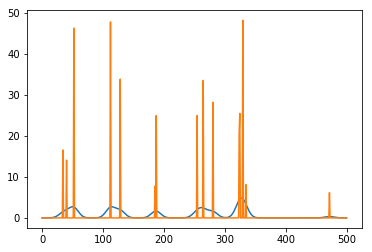

In [543]:
plt.plot(meas.numpy())
plt.plot(u.numpy())

In [544]:
def l1solv(Fw1,meas):
# Create variable.
   x_l1 = cp.Variable(shape=(N,1))
   constraints = [x_l1>=0]
# Form objective.
   obj = cp.Minimize(cp.norm(x_l1, 1)+cp.norm(Fw1.numpy()@x_l1-meas, 2)**2*1e3)
# Form and solve problem.
   prob = cp.Problem(obj, constraints)
   prob.solve()
   x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
   plt.plot(x_l1.value)
 #  return torch.norm(x2,0.1)*1e-20+torch.norm((Fw1@x2).reshape(500,1)-meas)*1e-2
   return net1(x2)#,torch.norm((Fw1@x2).reshape(500,1)-meas)*1e-10*2

In [545]:
np.linalg.norm(meas)

29.446455

left:677.0,right:7000.0, estimation:7000.0
left:728.0,right:7000.0, estimation:7000.0
left:728.0,right:7000.0, estimation:7000.0
left:728.0,right:7000.0, estimation:7000.0
left:728.0,right:7000.0, estimation:7000.0
left:970.0,right:7000.0, estimation:7000.0
left:970.0,right:7000.0, estimation:7000.0
left:1116.0,right:7000.0, estimation:7000.0
left:1379.0,right:7000.0, estimation:7000.0
left:1424.0,right:7000.0, estimation:7000.0
left:1455.0,right:7000.0, estimation:7000.0
left:1455.0,right:1729.0, estimation:1729.0
left:1455.0,right:1729.0, estimation:1729.0
left:1455.0,right:1729.0, estimation:1729.0
left:1455.0,right:1635.0, estimation:1635.0
left:1455.0,right:1635.0, estimation:1635.0
left:1455.0,right:1635.0, estimation:1635.0
left:1455.0,right:1620.0, estimation:1620.0
left:1455.0,right:1620.0, estimation:1620.0
left:1455.0,right:1612.0, estimation:1612.0
left:1455.0,right:1612.0, estimation:1612.0
left:1455.0,right:1612.0, estimation:1612.0
left:1455.0,right:1612.0, estimation:16

KeyboardInterrupt: 

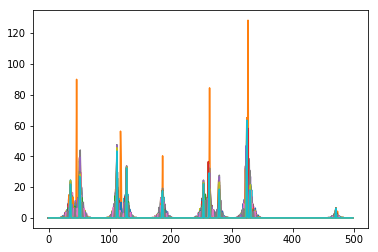

In [546]:
import cvxpy as cp
lf = 500
rb = 7000
mid = (lf+rb)/2
Fl = l1solv(torch.matrix_power(A, int(lf)),meas)
Fr = l1solv(torch.matrix_power(A, int(rb)),meas)
thr=1e-5*np.linalg.norm(meas)
walk =300;
for j in range(100):
    if j==40:
        walk = 300
    if (Fl>thr) & (Fr<thr):
      mid = lf + np.random.randint(-walk,walk)
      Fm = l1solv(torch.matrix_power(A, int(mid)),meas)
      if Fm>thr:
        if mid > lf:
           lf = mid
      else:
        if mid <rb:
          rb = mid
    elif Fl<thr:
        lf = lf/2
    else:
        rb = rb+1000
    print('left:{:.1f},right:{:.1f}, estimation:{:.1f}'.format(lf,rb,max(lf,rb)))
# Create variable.

In [380]:
x0.shape

(500, 1)